<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author"> Grupo 10: Álvaro José Álvarez Arranz </div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard).

In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import KernelCenterer
from sklearn.preprocessing import StandardScaler

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$. We assume it is centered.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size, the examples used will be simple ones. We recommend the use of `eig` from `scipy` for computing the first `n_components` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors found should be flipped in terms of their sign to obtain always the same result.
* Projected data should be centered inside the method (so it has zero mean, but the std remains the same), being careful to also centered the projected new data points. For this purpose you can use the method [KernelCenterer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KernelCenterer.html) from sklearn.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import eigh

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel, gamma=None):
        # Assignment of the hyper-parameters (complete).
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X):
        # Almacenamos los datos para usarlos en la transformación
        self.X_fit_ = X

        # Calculamos la matriz de kernel
        if self.kernel == 'linear':
            self.kernel_matrix = np.dot(X.T, X)
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1.0 / X.shape[1]
            self.kernel_matrix = rbf_kernel(X, gamma=self.gamma)
        else:
            raise ValueError(f"Kernel '{self.kernel}' no implementado. Use 'linear' o 'rbf'.")

        # Centramos el kernel usando KernelCenterer
        self.centerer = KernelCenterer()
        self.kernel_matrix_centered_ = self.centerer.fit_transform(self.kernel_matrix)

        # Descomposición de la matriz
        eigvals, eigvecs = eigh(self.kernel_matrix_centered_)

        # Ordenamos los autovalores
        sorted_idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_idx]
        eigvecs = eigvecs[:, sorted_idx]

        # Seleccionar los n_components principales
        self.eigvals = eigvals[:self.n_components]
        self.eigvecs = eigvecs[:, :self.n_components]

        if kernel == 'rbf':
          # Normalizar los autovectores
          self.eigvecs = self.eigvecs / np.sqrt(self.eigvals[np.newaxis, :])

        return self


    def transform(self, X):
        if self.kernel == "linear":
            return np.dot(X, self.eigvecs)  # Linear transformation
        elif self.kernel == 'rbf':
            K = rbf_kernel(X, self.X_fit_, gamma=self.gamma)  # Kernel matrix between new data and training data

            # Centrar el nuevo kernel usando el KernelCenterer del fit
            K_centered = self.centerer.transform(K)

            # Projecting the data
            return np.dot(K_centered, self.eigvecs / np.sqrt(self.eigvals[np.newaxis, :]))
        else:
            raise ValueError(f"Kernel '{self.kernel}' not implemented. Use 'linear' or 'rbf'.")

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

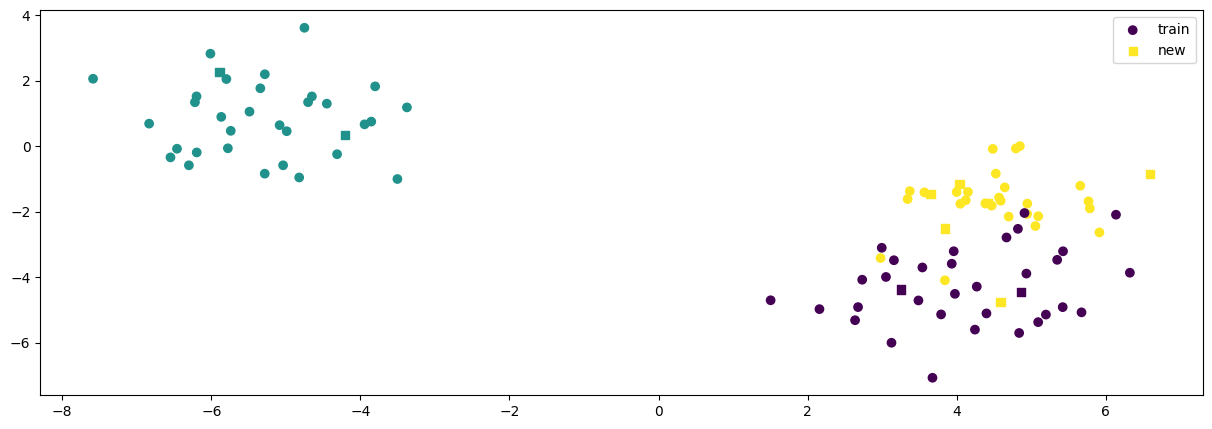

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

Autovectores implementados:
[[-0.70710678  0.70710678]]
Autovectores sklearn:
[[-0.70710678  0.70710678]]


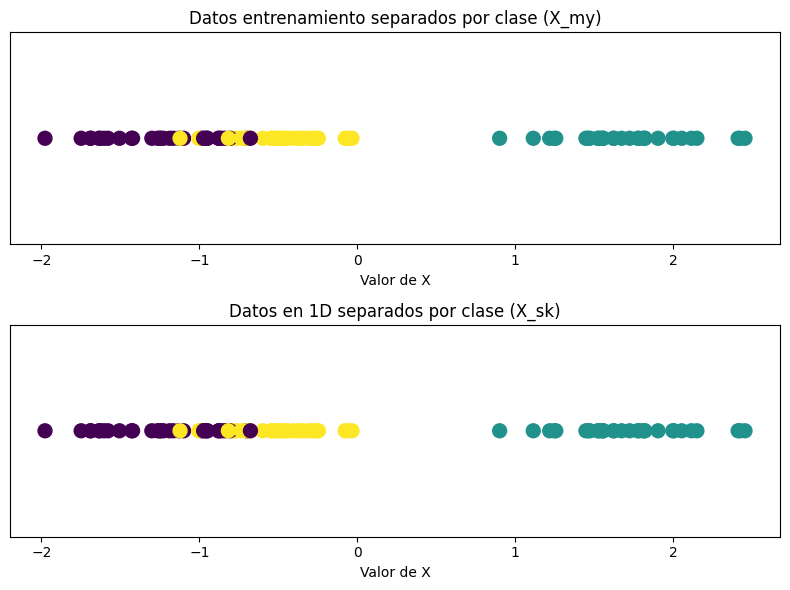

In [ ]:
from sklearn.decomposition import PCA

# Procesamos los datos dado que sklearn NO lo hace
scaler = StandardScaler()
scaler.fit(X_train)
X_scaler = scaler.transform(X_train)

kernel = 'linear'
n_components=1

model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = PCA(n_components=n_components)

# Training of the models (complete).
X_my = model_my.fit_transform(X_scaler)
X_sk = model_sk.fit_transform(X_scaler)

# Comparative of the eigenvectors (complete).
print("Autovectores implementados:")
print(model_my.eigvecs.T)

print("Autovectores sklearn:")
print(model_sk.components_)

# Comparative of the projections (complete).
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna

# Primera subgráfica con los datos de X_my
ax1.scatter(X_my, [0]*len(X_my), c=y_train, cmap='viridis', s=100)
ax1.set_title('Datos entrenamiento separados por clase (X_my)')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_sk
ax2.scatter(X_sk, [0]*len(X_sk), c=y_train, cmap='viridis', s=100)
ax2.set_title('Datos en 1D separados por clase (X_sk)')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Podemos observar que los datos están mejor separados en la clase azul que en las otras dos clases. Esto se debe a que en la gráfica original la clase azúl está más separada que las otras dos clases.

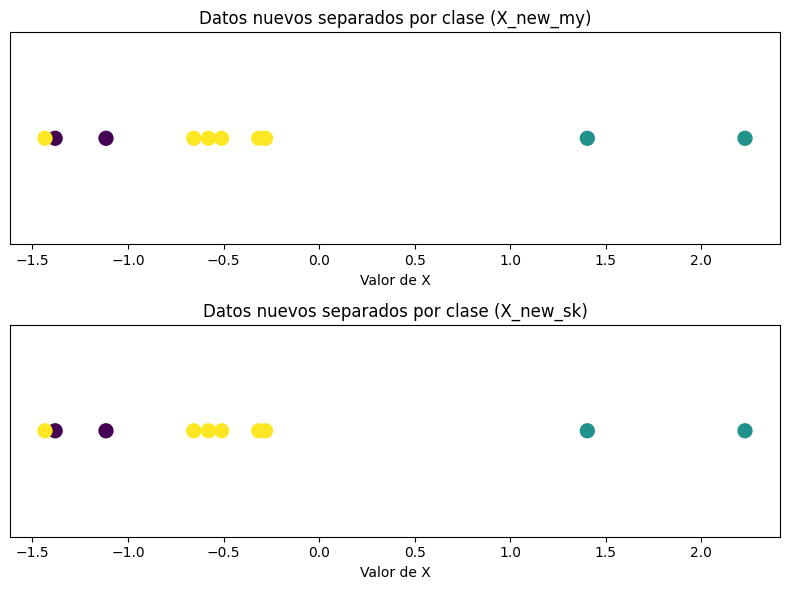

In [ ]:
# Transformamos los datos new con el StandarScaler de los datos train
X_new_scaler = scaler.transform(X_new)

# Transformamos los datos escalados X_new_scaler con los modelos entrenados
X_new_my = model_my.transform(X_new_scaler)
X_new_sk = model_sk.transform(X_new_scaler)

# Hacemos la comparativa
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna

# Primera subgráfica con los datos de X_new_my
ax1.scatter(X_new_my, [0]*len(X_new_my), c=y_new, cmap='viridis', s=100)
ax1.set_title('Datos nuevos separados por clase (X_new_my)')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_new_sk
ax2.scatter(X_new_sk, [0]*len(X_new_sk), c=y_new, cmap='viridis', s=100)
ax2.set_title('Datos nuevos separados por clase (X_new_sk)')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Podemos observar que los datos de la clase azul está mejor separada que los datos transformados en las otras dos clases. Esto es porque las nubes de puntos de entrenamiento amarilla y morada están parcialmente solapadas.

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [ ]:
from sklearn.decomposition import KernelPCA

# Procesamos los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_scaler = scaler.transform(X_train)

kernel = 'rbf'
n_components=2

# Model definition and fitting.
model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = KernelPCA()

X_my_kpca = model_my.fit_transform(X_scaler)
X_sk_kpca = model_sk.fit_transform(X_scaler)

# Comparative of the eigenvectors (complete).
print("Autovectores implementados:")
print(model_my.eigvecs.shape)

print("Autovectores sklearn:")
print(model_sk.eigenvectors_.shape)


Autovectores implementados:
(90, 2)
Autovectores sklearn:
(90, 2)


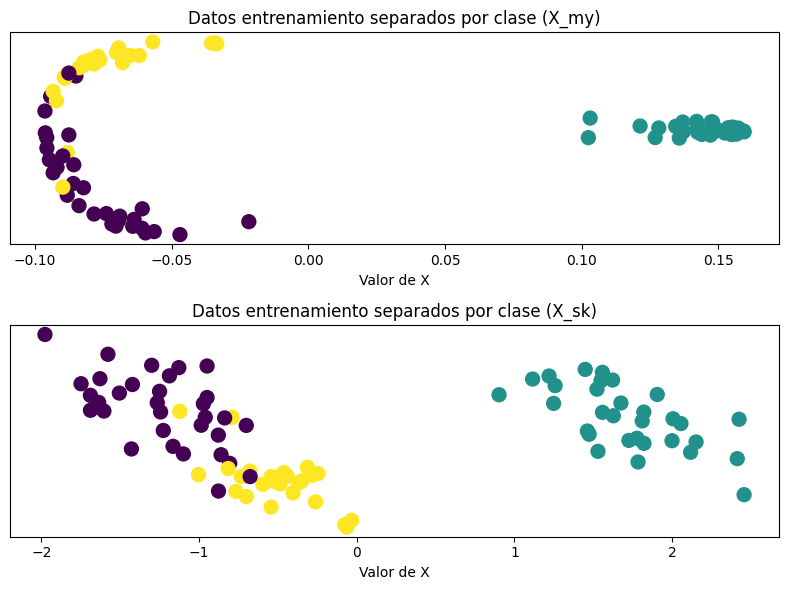

In [ ]:
# Comparative of the projections (complete).
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna

# Primera subgráfica con los datos de X_my
ax1.scatter(X_my_kpca[:,0], X_my_kpca[:,1], c=y_train, cmap='viridis', s=100)
ax1.set_title('Datos entrenamiento separados por clase (X_my)')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_sk
ax2.scatter(X_sk_kpca[:,0], X_sk_kpca[:,1], c=y_train, cmap='viridis', s=100)
ax2.set_title('Datos entrenamiento separados por clase (X_sk)')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Podemos apreciar que KernelPCA obtiene una matriz con un `shape` de (90,2). Esto se debe a que este clasificador no es lineal como PCA, por lo que ya entra en un espacio bidimensional que es la principal razón para elegir `n_components=2`. Lo mismo pasa con la clase implementada al pasar por `rbf_kernel` obteniendo una matriz de `shape` (90,2). Esto ocurre porque se está pasando 90 datos de dos dimensiones.

Comparando los datos transformados entre la clase implementada y la clase skLearn, podemos observar que la separación entre clases es, a efectos prácticos igual, siendo la clase azul la que mejor se separa de las otras dos que están casi solapadas.


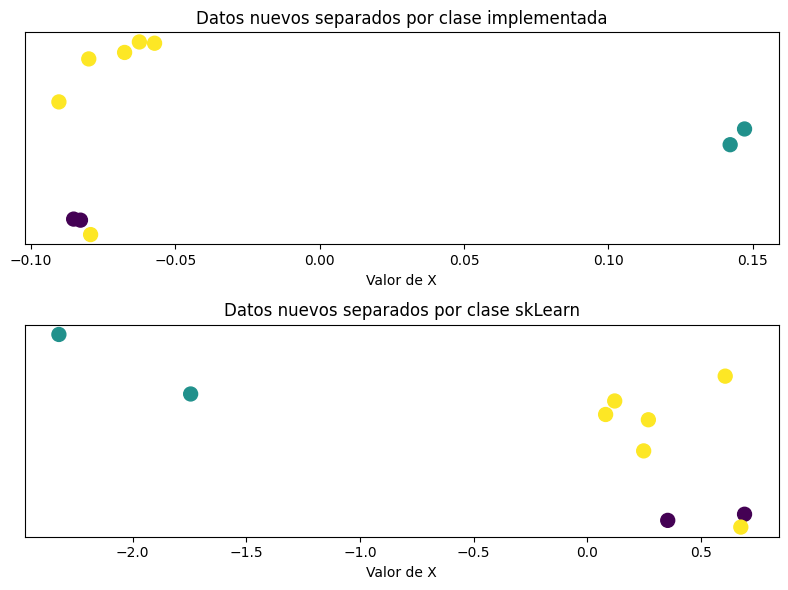

In [ ]:
# Transformamos los datos new con el StandarScaler de los datos train
X_new_scaler = scaler.transform(X_new)

# Transformamos los datos escalados X_new_scaler con los modelos entrenados
X_new_my_kpca = model_my.transform(X_new_scaler)
X_new_sk_kpca = model_sk.transform(X_new_scaler)

# Hacemos la comparativa
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna

# Primera subgráfica con los datos de X_new_my
ax1.scatter(X_new_my_kpca[:,0], X_new_my_kpca[:,1], c=y_new, cmap='viridis', s=100)
ax1.set_title('Datos nuevos separados por clase implementada')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_new_sk
ax2.scatter(X_new_sk_kpca[:,0], X_new_sk_kpca[:,1], c=y_new, cmap='viridis', s=100)
ax2.set_title('Datos nuevos separados por clase skLearn')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Podemos ver en las gráficas que la separación entre la clase implementada y skLearn, aunque simétricas, son muy parecidas dando una separación prácticamente igual entre las clases.

## Comparing linear kernel against Gaussian kernel

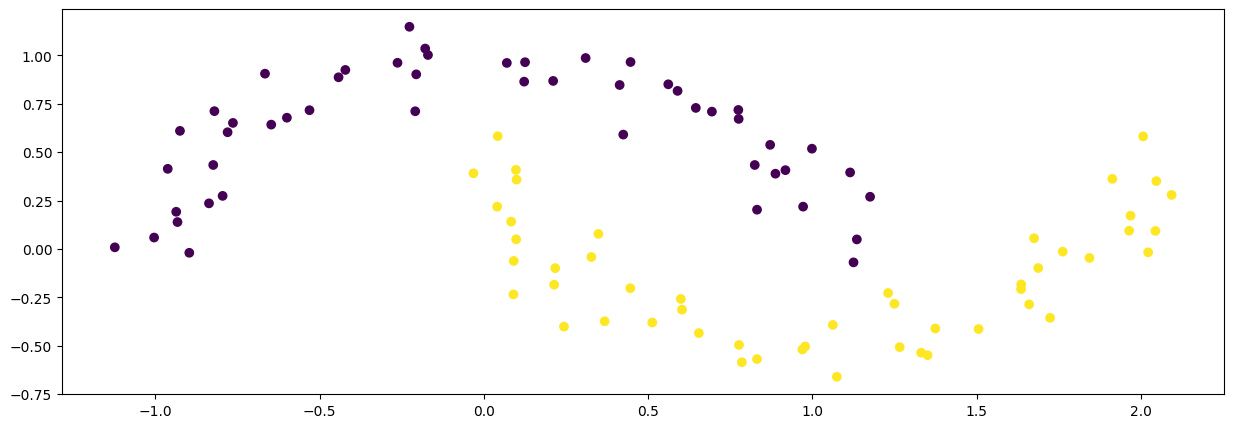

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

In [ ]:
model_linear = KPCA(n_components=1, kernel='linear')
model_rbf = KPCA(n_components=2, kernel='rbf')

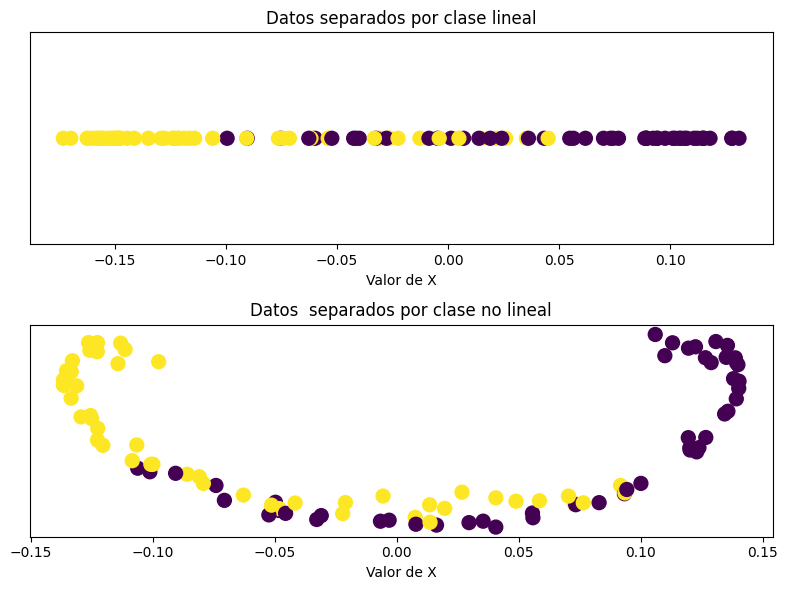

In [ ]:
X_linear = model_linear.fit_transform(X)
X_rbf = model_rbf.fit_transform(X)

# Comparative of the projections (complete).
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna

# Primera subgráfica con los datos de X_my
ax1.scatter(X_linear, [0] * len(X_linear), c=y, cmap='viridis', s=100)
ax1.set_title('Datos separados por clase lineal')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_sk
ax2.scatter(X_rbf[:,0], X_rbf[:,1], c=y, cmap='viridis', s=100)
ax2.set_title('Datos  separados por clase no lineal')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

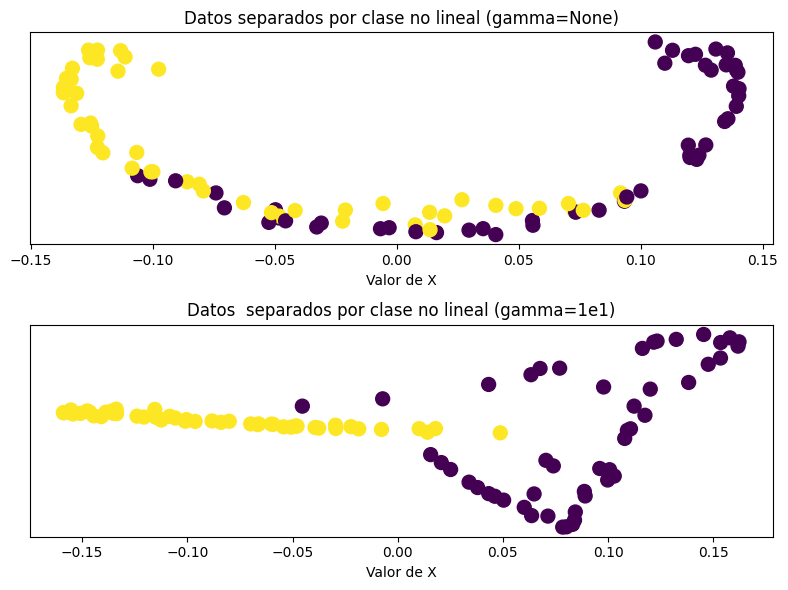

In [ ]:
model_rbf_2 = KPCA(n_components=2, kernel='rbf', gamma=1e1)
X_rbf_2 = model_rbf_2.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 filas, 1 columna
# Primera subgráfica con los datos de X_my
ax1.scatter(X_rbf[:,0], X_rbf[:,1], c=y, cmap='viridis', s=100)
ax1.set_title('Datos separados por clase no lineal (gamma=None)')
ax1.set_xlabel('Valor de X')
ax1.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Segunda subgráfica con los datos de X_sk
ax2.scatter(X_rbf_2[:,0], X_rbf_2[:,1], c=y, cmap='viridis', s=100)
ax2.set_title('Datos  separados por clase no lineal (gamma=1e1)')
ax2.set_xlabel('Valor de X')
ax2.set_yticks([])  # Ocultar eje Y en esta subgráfica

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Podemos observar en la comparación entre las diferentes clasificaciones que tanto para PCA como para KPCA con `gamma=None`, al separar los datos, aún hay puntos que quedan solapados, mientras que si se elige unn `gamma=1e1` la separación entre clases es mejor dado que la clase amarilla queda en una linea mientras que la clase morada está fuera de esta línea.